**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did an excellent job! The project is accepted. Keep up the good work on the next sprint!

# Introduction to Machine Learning Project
Mobile carrier Megaline has found out that many of their subscribers use legacy plans. They want to develop a model that would analyze subscribers' behavior and recommend one of Megaline's newer plans: Smart or Ultra.
We have access to behavior data about subscribers who have already switched to the new plans (from the project for the Statistical Data Analysis course). For this classification task, we need to develop a model that will pick the right plan. Since we’ve already performed the data preprocessing step, we can move straight to creating the model.

## Data Preparation
Every observation in the dataset contains monthly behavior information about one user. The information given is as follows:
- `сalls` — number of calls,
- `minutes` — total call duration in minutes,
- `messages` — number of text messages,
- `mb_used` — Internet traffic used in MB,
- `is_ultra` — plan for the current month (Ultra - 1, Smart - 0).

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
import warnings

In [2]:
try:
    df = pd.read_csv('users_behavior.csv')
except:
    df = pd.read_csv('/datasets/users_behavior.csv')

A quick overview of the data.

In [3]:
df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
calls,3214.0,63.038892,33.236368,0.0,40.0000,62.000,82.0000,244.00
minutes,3214.0,438.208787,234.569872,0.0,274.5750,430.600,571.9275,1632.06
messages,3214.0,38.281269,36.148326,0.0,9.0000,30.000,57.0000,224.00
mb_used,3214.0,17207.673836,7570.968246,0.0,12491.9025,16943.235,21424.7000,49745.73
is_ultra,3214.0,0.306472,0.461100,0.0,0.0000,0.000,1.0000,1.00


Means and medians are quite close. Also note that most users switched to Smart

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


We can cut the dataset size in half.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Not a bad idea, but a bit unnecessary as our dataset is already only 125 KB :)

</div>

In [6]:
for column in df.columns:
    if df[column].dtype == 'float64':
        df[column] = df[column].astype('float32')
    elif df[column].dtype == 'int64':
        df[column] = df[column].astype('int32')

We will split the data into a training set, a varification set and a test set.

In [7]:
X, y = df.drop(['is_ultra'], axis=1), df['is_ultra']
X_trva, X_test, y_trva, y_test = train_test_split(X, y, random_state=42069, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_trva, y_trva, random_state=42069, test_size=0.25)

And verify it is split 60-20-20 like we intended.

In [8]:
pd.Series([y_train.count(), y_valid.count(), y_test.count()], index=['train', 'valid', 'test'])/y.count()

train    0.599876
valid    0.200062
test     0.200062
dtype: float64

All set.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, the data was split into train, validation and test sets. The proportions are reasonable!

</div>

## Logistic Regression Model
We'll start with the simplest, logistic regression. First we'll figure out which solver perform better on this problem.

In [32]:
for solver in ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']:
    lr_model = LogisticRegression(solver=solver, random_state=42069)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        lr_model.fit(X_train, y_train)
    print(f'solver={solver}: {lr_model.score(X_valid, y_valid)}')

solver=newton-cg: 0.749611197511664
solver=lbfgs: 0.7076205287713841
solver=liblinear: 0.7465007776049767
solver=sag: 0.6936236391912908
solver=saga: 0.6936236391912908


`newton-cg` and `liblinear` are almost there. The default penalty is `l2`, but there is one other available option for each solver.

In [10]:
lr_model = LogisticRegression(solver='liblinear', penalty='l1', random_state=42069)
lr_model.fit(X_train, y_train)
lr_model.score(X_valid, y_valid)

0.7465007776049767

In [11]:
lr_model = LogisticRegression(solver='newton-cg', penalty='none', random_state=42069)
lr_model.fit(X_train, y_train)
lr_model.score(X_valid, y_valid)

0.749611197511664

It gives exactly the same results, but at least without non-convergence warnings. Let's also try the `balanced` class weight option.

In [30]:
lr_model = LogisticRegression(solver='newton-cg', class_weight='balanced', random_state=42069)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_model.fit(X_train, y_train)
lr_model.score(X_valid, y_valid)

0.6438569206842923

In [13]:
lr_model = LogisticRegression(solver='liblinear', class_weight='balanced', random_state=42069)
lr_model.fit(X_train, y_train)
lr_model.score(X_valid, y_valid)

0.6314152410575428

It just made it worse. So the final logistic regression model that will now face the test set is the `newton-cg` solver with no penalty.

<div class="alert alert-success">
<b>Reviewer's comment</b>

It made it worse in terms of accuracy, but as it turns out accuracy is not really a good metric for imbalanced data. The next project explores these themes further!

</div>

In [31]:
lr_model = LogisticRegression(solver='newton-cg', penalty='none', random_state=42069)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr_model.fit(X_trva, y_trva)
lr_score = lr_model.score(X_test, y_test)
lr_score

0.7418351477449455

We are less than 1% from the target accuracy, but almost is not enough. On top of that, the model did not converge. The task is too complicated for logistic regression.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Alright, the final model was evaluated on the test set

</div>

## Decision Tree Model
Next is the decision tree model. First we'll see how the default tree is doing.

In [15]:
tree_model = DecisionTreeClassifier(random_state=42069)
tree_model.fit(X_train, y_train)
tree_model.score(X_valid, y_valid)

0.7216174183514774

Not amazing. When unlimited, its depth reaches the following value.

In [16]:
default_depth = tree_model.get_depth()
default_depth

26

The next block will loop through various hyper-parameters and pick the best ones for us.

In [17]:
best_tree = {
    'max_depth': 1,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'score': 0
}

for depth in range(1, default_depth+1):
    for leaf in range(1, 10):
        for split in range(leaf*2, leaf*10, int(leaf*0.5+0.5)):
            tree_model = DecisionTreeClassifier(
                random_state=42069, 
                max_depth=depth, 
                min_samples_split=split, 
                min_samples_leaf=leaf
            )
            tree_model.fit(X_train, y_train)
            score = tree_model.score(X_valid, y_valid)
            
            if score > best_tree['score']:
                (best_tree['max_depth'], best_tree['min_samples_split'], 
                 best_tree['min_samples_leaf'], best_tree['score']) = (depth, split, leaf, score)
                print(best_tree)

{'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 1, 'score': 0.749611197511664}
{'max_depth': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'score': 0.7729393468118196}
{'max_depth': 3, 'min_samples_split': 2, 'min_samples_leaf': 1, 'score': 0.7978227060653188}
{'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'score': 0.7993779160186625}
{'max_depth': 6, 'min_samples_split': 14, 'min_samples_leaf': 7, 'score': 0.8009331259720062}
{'max_depth': 7, 'min_samples_split': 16, 'min_samples_leaf': 5, 'score': 0.80248833592535}
{'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 1, 'score': 0.8133748055987559}
{'max_depth': 8, 'min_samples_split': 13, 'min_samples_leaf': 5, 'score': 0.8149300155520995}


The best tree that we found is much shallower and has larger leaves than the initial tree, that was probably overfitted. Now let's put it to the test. 

In [18]:
tree_model = DecisionTreeClassifier(
    random_state=42069, 
    max_depth=best_tree['max_depth'], 
    min_samples_split=best_tree['min_samples_split'], 
    min_samples_leaf=best_tree['min_samples_leaf']
)
tree_model.fit(X_trva, y_trva)
tree_score = tree_model.score(X_test, y_test)
tree_score

0.7900466562986003

It has surpassed our accuracy goal with a comfortable margin.

## Random Forest Model
If a single tree is doing so well, imagine what a forest can do. 

In [19]:
for n in range(50, 501, 50):
    forest_model = RandomForestClassifier(random_state=42069, n_estimators=n)
    forest_model.fit(X_train, y_train)
    print(f'n={n}: {forest_model.score(X_valid, y_valid)}')

n=50: 0.7993779160186625
n=100: 0.8009331259720062
n=150: 0.8055987558320373
n=200: 0.807153965785381
n=250: 0.807153965785381
n=300: 0.8102643856920684
n=350: 0.807153965785381
n=400: 0.8087091757387247
n=450: 0.807153965785381
n=500: 0.807153965785381


It's not bad, but since we already have the optimal tree, we might as well clone an entire forest out of it.

In [20]:
for n in range(50, 501, 50):
    forest_model = RandomForestClassifier(
        random_state=42069, 
        n_estimators=n, 
        max_depth=best_tree['max_depth'], 
        min_samples_split=best_tree['min_samples_split'], 
        min_samples_leaf=best_tree['min_samples_leaf']
    )
    forest_model.fit(X_train, y_train)
    print(f'n={n}: {forest_model.score(X_valid, y_valid)}')

n=50: 0.8133748055987559
n=100: 0.8149300155520995
n=150: 0.8164852255054432
n=200: 0.8195956454121306
n=250: 0.8195956454121306
n=300: 0.8195956454121306
n=350: 0.8180404354587869
n=400: 0.8180404354587869
n=450: 0.8180404354587869
n=500: 0.8180404354587869


It did edge the first batch of forests. Moreover, we only need 200 estimators for best results, compared with 300 previously. Now for the test.

In [21]:
forest_model = RandomForestClassifier(
    random_state=42069, 
    n_estimators=200, 
    max_depth=best_tree['max_depth'], 
    min_samples_split=best_tree['min_samples_split'], 
    min_samples_leaf=best_tree['min_samples_leaf']
)
forest_model.fit(X_trva, y_trva)
forest_score = forest_model.score(X_test, y_test)
forest_score

0.8055987558320373

200 optimized trees did better than one.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, you tried a couple of other different models and tuned their hyperparameters using the validation set. Final models were evaluated on the test set

</div>

## Conclusion
The results of this analysis are shown in the following plot, along with a 'sanity check' model that predicts all users will do what most users did, i.e. move to the 'Smart' plan.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, a constant model always predicting the majority class is indeed a pretty good baseline in terms of accuracy

</div>

In [22]:
sanity_score = max(y_test.mean(), 1-y_test.mean())

In [23]:
labels = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Sanity Check']
scores = [lr_score, tree_score, forest_score, sanity_score]
colors = ['C0', 'C1', 'C2', 'C3']

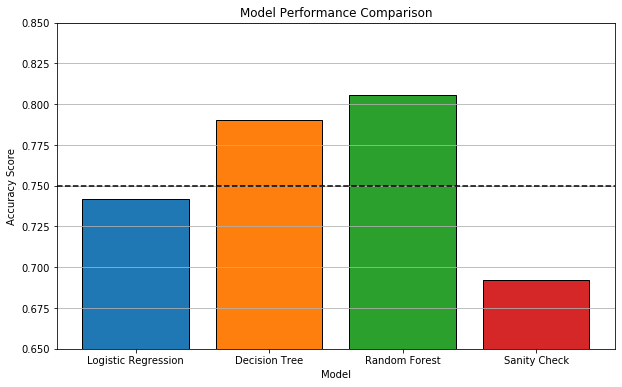

In [24]:
plt.figure(figsize=(10, 6))
plt.ylim(0.65, 0.85)
plt.grid(visible=True, axis='y')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.title('Model Performance Comparison')
plt.bar(labels, scores, color=colors, edgecolor='k')
plt.axhline(0.75, linestyle='--', color='k')
plt.show()

All models passed the sanity check. The logistic regression model's simplicity makes it resistant to overfitting, yet prone to underfitting, and in our case it just couldn't make the cut - but it got pretty close with a little tinkering. Both the decision tree and random forest models made it above and behind our 75% accuracy criterion. The combined power of 200 trees gives the forest a 1.5% advantage over the single tree. On the downside, random forests can take some time to learn, so if time is an issue, it's good to know that the faster single tree also passed the test.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Conclusions make sense!

</div>